# **Default Setting**

* Python: 3.6.9
* ML Framework: tensorflow-gpu 2.4.0 / tensorflow-addons 0.12.0
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: Linux Ubuntu 20.04 LTS (desktop)

Install below APIs using anaconda as belows.

```
conda create -n py36 python=3.6.9
conda acitvate py36
conda install jupyterlab
pip3 install tensorflow-gpu=2.4.0
pip3 install tensorflow-addons
conda install pandas, matplotlib
```

And now, you can run jupyter lab (or jupyter notebook).

```
jupyter lab
```

In [1]:
%env NOTEBOOKNAME try45
%env LOCAL_DATA_PATH data
%env CHECKPOINT_PATH ckpt
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try45
env: LOCAL_DATA_PATH=data
env: CHECKPOINT_PATH=ckpt
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import platform
import pprint

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.4.0
tfa.__version__: 0.12.0


In [3]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Sat Dec 26 16:07:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   37C    P2    30W / 220W |    373MiB /  7979MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       1.3Gi        26Gi        11Mi       3.1Gi        29Gi
Swap:         2.0Gi          0B       2.0Gi


In [9]:
# platform.platform()

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [11]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 50,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    "DAY": 48,
    
    # Dataset Pipeline
    "WINDOW_INP": 7,    # 7 days
    "WINDOW_TAR": 2,    # 2 days
    "WINDOW_SHIFT": 1,  # 1 day
    "WINDOW_STRIDE": 1, # 1 day
    "WINDOW_DR": True,  # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 128, # lstm & dense units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 50),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('DAY', 48),
             ('WINDOW_INP', 7),
             ('WINDOW_TAR', 2),
             ('WINDOW_SHIFT', 1),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 128),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Define Preprocessing Funciton**

In [12]:
def preprocessing(df, is_training = True, day = args["DAY"]): # 24 / 0.5 [h]
    # Drop timestampes.
    try:
        # We cannot use day features, thus there is no day-position in test dataset.
        df = df.drop(["Day"], axis = 1) 
    except:
        pass
    
    
    # Timestamp to sin/cos.
    df["Time"] = 2 * df["Hour"].map(int) + (df["Minute"].map(int) // 30)
    
    day_sin = np.sin(df["Time"] * (2 * np.pi / day))
    day_cos = np.cos(df["Time"] * (2 * np.pi / day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "Time"], axis = 1)
    
    
    # Standarize.
    for column in df.columns:
        df[column] = df[column].map(np.float32)
        if is_training:
            args[f"{column}_MEAN"] = df[column].mean()
            args[f"{column}_STD"] = df[column].std()
        
        df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

## **Train & Validation Dataframes**

In [13]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))
df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [14]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))
args["SPLIT_LEN"] = args["SPLIT_LEN"] - np.mod(args["SPLIT_LEN"], args["DAY"])

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

tr_df.shape, vl_df.shape

((42048, 8), (10512, 8))

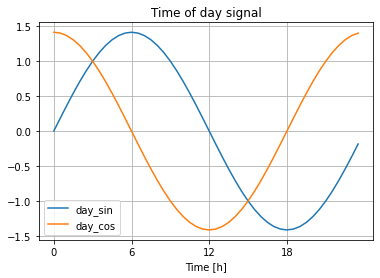

In [16]:
plt.plot(np.array(tr_df["DAY_SIN"])[:args["DAY"]], label = "day_sin")
plt.plot(np.array(tr_df["DAY_COS"])[:args["DAY"]], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.grid(True)
plt.title('Time of day signal')
plt.show()

## **Test Dataframe**

In [17]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

ts_df.shape

(27216, 8)

# **Make Dataset Pipelines**

The first batch is to bundle the tensors as input into units of a day. The operation below can guarantee that the number of sequences of tr_tensor and vl_tensor is a multiple of a day (i.e. 48), so `drop_remainder = True` is actually meaningless. However, it was added to specify the shape of the input data during the window division process (`.window(...)`)

```
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))
args["SPLIT_LEN"] = args["SPLIT_LEN"] - np.mod(args["SPLIT_LEN"], args["DAY"]) # this process

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]
```

It is recommended to cache the dataset after the map transformation except if this transformation makes the data too big to fit in memory. A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part. In this case, you can chain your transformations like below:

```
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

If the cache is executed after partioning the window, the amount of data loaded in the memory increases by about 9 times (=`(WINDOW_INP + WINDOW_TAR) / WINDOW_STRIDE)`. Obviously, the mapping process comsumes a lot of time, but since we have to train a model like this 9 times, it would be desirable to load it into the cache mory before the window split.

Also `cache` produce exactly the same elements during each iteration through the dataset. If you wish to randomize the iteration order, make sure to call `shuffle` after calling `cache`.

Immediately after the window is splited, the mapping function `_split_window` is called after stacking with `GLOBAL_BATCH_SIZE`. This time, the vectorized mapping function is called once and applies to a batch of sample. While the function could takes more time to execute, the overhead appear only once, improving the overall time performance.
        
*References*
   * *https://www.tensorflow.org/guide/data_performance*
   * *https://www.tensorflow.org/api_docs/python/tf/data/Dataset*

In [18]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    """
        input:  [batch, 9, 48, 8] = [batch, WINDOW_INP + WINDOW_TAR, DAY, NUM_FEATURES + ANSWER]
        output: [batch, 7, 48, 7], (aux: [batch, 2, 48, 7], real: [batch, 2, 48, 1])
    """
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 1)
    
    # Same as "return inp[..., :-1], (tar[..., :-1], tar[..., -1:])".
    inp, _ = tf.split(inp, [args["NUM_FEATURES"], -1], axis = -1)
    aux, real = tf.split(tar, [args["NUM_FEATURES"], -1], axis = -1)
    
    return inp, (aux, real)
    

@tf.function
def _split_window_ts(features):
    """
        input:  [batch, 7, 48, 8] = [batch, WINDOW_INP, DAY, NUM_FEATURES + ANSWER]
        output: [batch, 7, 48, 7]
    """
    inp, _ = tf.split(features, [args["NUM_FEATURES"], -1], axis = -1)
    
    return inp

In [20]:
# Dataframe to tensor.
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

# Tensor to dataset.
tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).batch(args["DAY"], drop_remainder = True
                    ).cache(
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).shuffle(10_000, reshuffle_each_iteration = True
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).batch(args["DAY"], drop_remainder = True
                    ).cache(
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
#                     ).shuffle(10_000, reshuffle_each_iteration = True
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).batch(args["DAY"], drop_remainder = True
#                     ).cache(
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
#                     ).shuffle(10_000, reshuffle_each_iteration = True
                    ).batch(args["NUM_TEST_CSV"], # not GLOBA_BATCH_SIZE
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
                    ).prefetch(args["AUTO"])

# Print the shapes.
print("tr_dataset:")
print(f"\tinp: {tr_dataset.element_spec[0]}")
print(f"\ttar:")
print(f"\t\t aux: {tr_dataset.element_spec[1][0]}")
print(f"\t\treal: {tr_dataset.element_spec[1][1]}")

print("vl_dataset:")
print(f"\tinp: {vl_dataset.element_spec[0]}")
print(f"\ttar:")
print(f"\t\t aux: {vl_dataset.element_spec[1][0]}")
print(f"\t\treal: {vl_dataset.element_spec[1][1]}")

print("ts_dataset:")
print(f"\tinp: {ts_dataset.element_spec}")

tr_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 7), dtype=tf.float32, name=None)
	tar:
		 aux: TensorSpec(shape=(None, 2, 48, 7), dtype=tf.float32, name=None)
		real: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
vl_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 7), dtype=tf.float32, name=None)
	tar:
		 aux: TensorSpec(shape=(None, 2, 48, 7), dtype=tf.float32, name=None)
		real: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
ts_dataset:
	inp: TensorSpec(shape=(None, None, 48, 7), dtype=tf.float32, name=None)


## **Take Samples**

In [21]:
for element in tr_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 7, 48, 7) (128, 2, 48, 7) (128, 2, 48, 1)


In [22]:
for element in vl_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 7, 48, 7) (128, 2, 48, 7) (128, 2, 48, 1)


In [23]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 7, 48, 7)


# **Define Loss Function**

Dacon defines the loss as shown below.

$$ L_\tau = maximum(\zeta\tau, \zeta(\tau-1)) $$

However, [the pinball loss of tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss) is implemented as follows.

$$ L_\tau = \begin{cases} \zeta\tau & \text{ if } \zeta \geq 0 \\ -\zeta(1-\tau)=\zeta(\tau-1) & \text{ if } \zeta < 0 \end{cases}$$

The description of the symbols used in is as follows.

* $\zeta$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]
* $L_\tau$ : Pinball loss function with $\tau$

The two formulas seem intuitively different, but if you actually divide the interval, you can see that they are the same. However, in experience, it seems to force an underforecast when the evaluation expression of dacon is $\tau=0.1, 0.2$. In fact, for $\tau=0.1, 0.2$, the prediction (blue lines) in the target models mostly overlaps the label (yellow lines) or lies below the graph.

In [24]:
# Define customized pinball loss function, named tuned_pinball_loss thus there exists finely differences 
# between the function of tensorflow-addons and the requirements of DACON.

# Ref: https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/losses/quantiles.py

@tf.function
def custom_pinball_loss(
    y_true: tf.Tensor, 
    y_pred: tf.Tensor, 
    tau: float = 0.5,
) -> tf.Tensor:
    """Computes the pinball loss between "y_true" and "y_pred" like dacon-style."""
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    tau = tf.cast(tau, y_pred.dtype)
    
    delta_y = tf.math.abs(y_true - y_pred)
    # It performs "tau = tau if y_true >= y_pred else (1 - tau)" for elemental-wise.
    _tau = tf.where(tf.math.greater_equal(y_true, y_pred), tau, 1 - tau)
    
    pinball = delta_y * _tau
    return tf.reduce_mean(pinball, axis = -1)


class CustomPinballLoss(tfa.utils.keras_utils.LossFunctionWrapper):
    def __init__(
        self,
        tau: tfa.utils.types.FloatTensorLike = 0.5,
        reduction: str = tf.keras.losses.Reduction.AUTO,
        name: str = "custom_pinball_loss",
    ):
        super().__init__(custom_pinball_loss, reduction = reduction, name = name, tau = tau)

# **Create Network**

## **Autoregressive-LSTM Model**

```
"""Pytorch Style with Class"""
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        aux_outputs, real_outputs = [], []
        
        prediction, state = self.warmup(inputs)
        
        aux_outputs.append(prediction)
        real_outputs.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            
            aux_outputs.append(prediction)
            real_outputs.append(self.target_model(prediction))
            
        aux_outputs = tf.stack(aux_outputs, axis = 1)
        real_outputs = tf.stack(real_outputs, axis = 1)
        return (aux_outputs, real_outputs)
```

When implementing a model using a functional API, you can use the powerful visualization function provided by keras. You can check the number of parameters for each layer by using the model.summary() function, and you can visualize the entire flow diagram of the model by using tf.keras.utils.plot_model().

By using these tasks, you can see the I/O size of each layer at a glance, so it will reduce the hassle of checking the shape by calling the function inside the class as follows.

```
# Make a tmperary model.
tmp = AR_LSTM(...)

# Make dummy dataset.
dummy_x = tf.zeros([args["GLOBAL_BATCH_SIZE"], args["WINDOW_INP"], args["NUM_FEATURES"]], dtype = tf.float32)
print(f"dummy_x.shape: {dummy_x.shape}")

# Check the shapes of wampup and call functions.
dummy_w, _ = tmp.warmup(dummy_x)
dummy_y, dummy_z = tmp(dummy_x)

# Print the shapes.
print(f"The shapes of warmup output: {dummy_w.shape}")
print(f"The shapes of auxiliary output: {dummy_y.shape}")
print(f"The shapes of real output: {dummy_z.shape}")
```

As a result, these tasks will have a positive impact on the future direction of the project by reminding you of the need to increase or decrease the size of the model.

In [56]:
def create_AR_LSTM(model_name, units = 32, out_steps = 2):
    convlstm2d = tf.keras.layers.ConvLSTM2D(units, 3, padding = "same", return_state = True)
    conv2d = tf.keras.layers.Conv2D(1, 1, padding = "same", activation = "relu")
    reshape = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1), name = "expand_timestamp_dims")
    squeeze = tf.keras.layers.Reshape((args["DAY"], args["NUM_FEATURES"]))
    predict = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(args["NUM_FEATURES"], activation = "relu"),
        tf.keras.layers.Dense(1)], name = "predict"))
    aux_outputs, real_outputs = [], []
    
    # Entry flow.
    model_input = tf.keras.layers.Input(
        shape = [args["WINDOW_INP"], args["DAY"], args["NUM_FEATURES"]], dtype = tf.float32)
    
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), name = "expand_filter_dims")(model_input)

    # warmup
    x, *state = convlstm2d(x)
    x = conv2d(x)
    aux_outputs.append(squeeze(x))
    real_outputs.append(predict(x))
    
    # Middle flow.
    for _ in range(1, out_steps):
        x = reshape(x)
        x, *state = convlstm2d(x, initial_state = state)
        x = conv2d(x)
        
        aux_outputs.append(squeeze(x))
        real_outputs.append(predict(x))
    
    # Exit flow.
    real_output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "real")(real_outputs)
    aux_output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "aux")(aux_outputs)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = [aux_output, real_output],
        name = model_name)

In [59]:
tmp = create_AR_LSTM("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 7, 48, 7)]   0                                            
__________________________________________________________________________________________________
expand_filter_dims (Lambda)     (None, 7, 48, 7, 1)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)     [(None, 48, 7, 32),  38144       expand_filter_dims[0][0]         
                                                                 expand_timestamp_dims[0][0]      
                                                                 conv_lst_m2d_9[0][1]             
                                                                 conv_lst_m2d_9[0][2]           

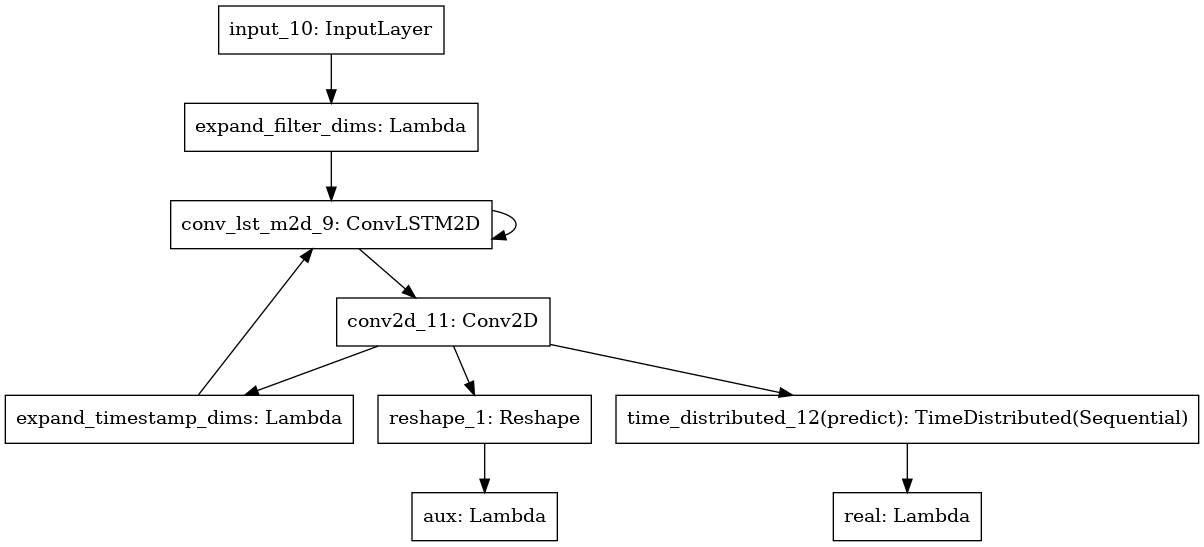

In [60]:
tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False, rankdir = "TB")

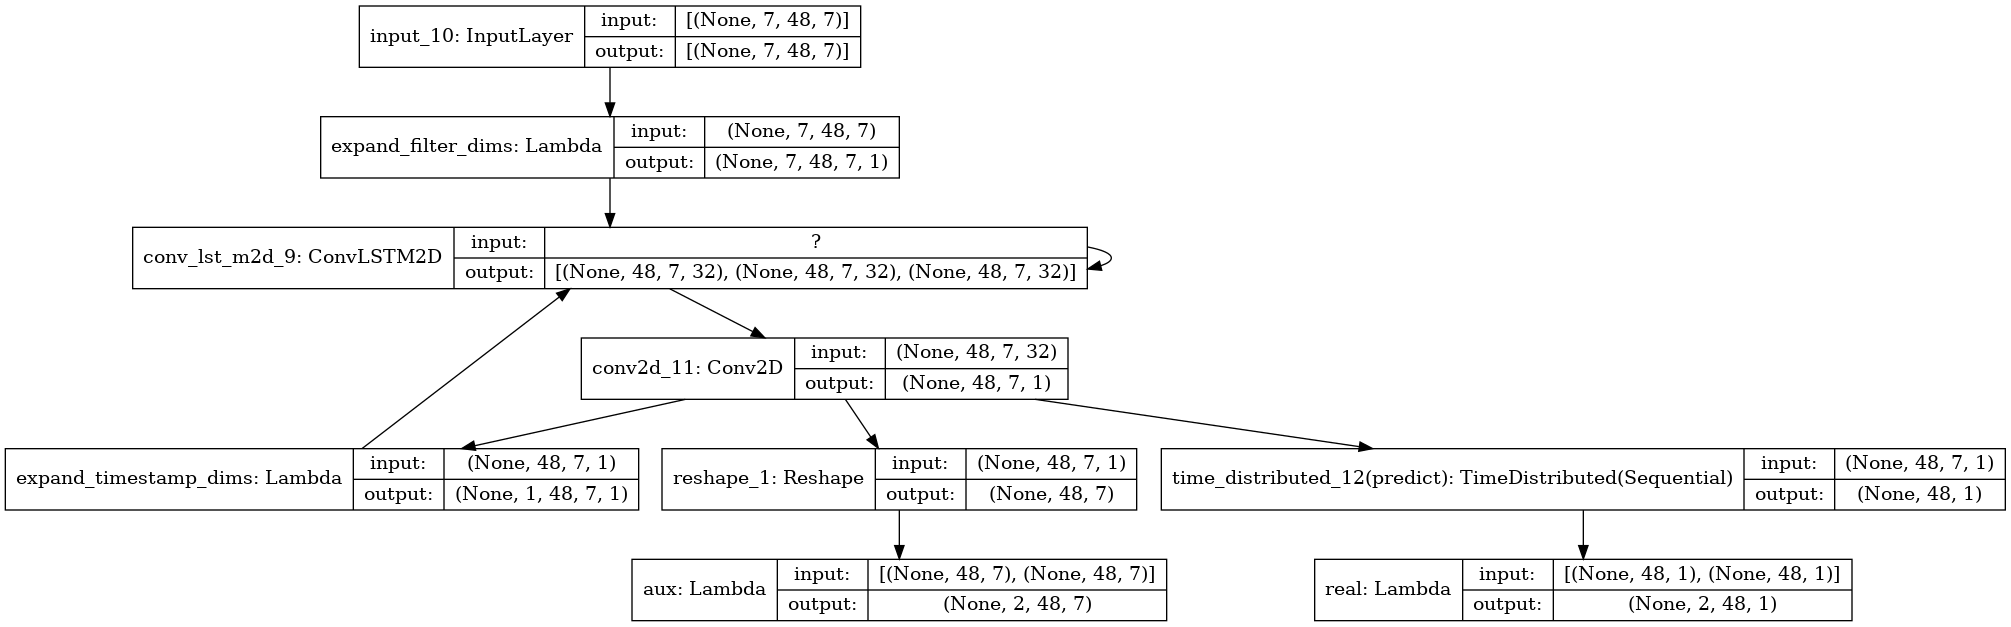

In [61]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [62]:
del tmp

# **Compile and Fit**

In [64]:
def get_callbacks(model_name: str):
    """Get checkpoint and tensorboard callbacks."""
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], 
        model_name, "cp-{epoch:03d}-{val_real_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_real_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], datetime.datetime.now().strftime(f"{model_name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
    
    return [cp_callback, tb_callback]
    

def compile_and_fit(model, tau, tr_dataset, vl_dataset, epochs, verbose = 0, loss_weights = None):
    """Compile and fit the model."""
    model.compile(
        loss = CustomPinballLoss(tau = tau),
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    print(f"Model {model.name}...")

    history = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = get_callbacks(model.name))

    return history

In [65]:
%%time

for tau in np.arange(0.1, 1, 0.1):
    model = create_AR_LSTM(model_name = f"P{tau:.1f}")
    
    _ = compile_and_fit(
        model, tau, tr_dataset, vl_dataset, args["EPOCH"], verbose = 2, loss_weights = [0.2, 1.0])
    
    del model # for save memories

Model P0.1...
Epoch 1/50
7/7 - 5s - loss: 0.4883 - aux_loss: 0.4322 - real_loss: 0.4019 - val_loss: 0.4564 - val_aux_loss: 0.4447 - val_real_loss: 0.3674
Epoch 2/50
7/7 - 0s - loss: 0.4241 - aux_loss: 0.4851 - real_loss: 0.3271 - val_loss: 0.3528 - val_aux_loss: 0.5603 - val_real_loss: 0.2407
Epoch 3/50
7/7 - 0s - loss: 0.3206 - aux_loss: 0.6553 - real_loss: 0.1895 - val_loss: 0.2886 - val_aux_loss: 0.7208 - val_real_loss: 0.1444
Epoch 4/50
7/7 - 0s - loss: 0.2575 - aux_loss: 0.6913 - real_loss: 0.1192 - val_loss: 0.2485 - val_aux_loss: 0.6133 - val_real_loss: 0.1259
Epoch 5/50
7/7 - 0s - loss: 0.2307 - aux_loss: 0.6015 - real_loss: 0.1104 - val_loss: 0.2224 - val_aux_loss: 0.6005 - val_real_loss: 0.1023
Epoch 6/50
7/7 - 0s - loss: 0.2137 - aux_loss: 0.6030 - real_loss: 0.0932 - val_loss: 0.2100 - val_aux_loss: 0.5934 - val_real_loss: 0.0913
Epoch 7/50
7/7 - 0s - loss: 0.2015 - aux_loss: 0.5871 - real_loss: 0.0840 - val_loss: 0.2011 - val_aux_loss: 0.5703 - val_real_loss: 0.0870
Epoch 

## **Make Clean Checkpoints**

In [ ]:
# %%time

# ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
# max_to_keep = 3

# for f in ckpt_folders:
#     # 7 files must be located in ckpt_folders. (latest 3 ckpt and checkpoint file)
#     assert len(os.listdir(f)) >= (1 + max_to_keep * 2), f"Checkpoints in {f} is less then 3 (max_to_keep)."
    
#     rm_files = os.listdir(f)[1:-2*max_to_keep] # [1:-6]
#     _ = [os.remove(rm_file) for rm_file in rm_files]

# **Visualize**

## **Plot Histories**

In [ ]:
def draw_histories(histories):
    """Draw 9 histories in one plot."""
    assert len(histories.keys) == args["NUM_QUANTILE"]
    
    plt.figure(figsize = (14, 9), facecolor = "white", dpi = 96)

    for model_name, history in histories.items():
        pos = int(model_name.split(".")[-1])
        plt.subplot(3, 3, pos)
                
        plt.plot(history.epoch, history.history["output_2_loss"], label = "output_2_loss")
        plt.plot(history.epoch, history.history["val_output_2_loss"], label = "val_output_2_loss")
    
        plt.legend()
        plt.title(title, fontsize = "x-large")
        plt.xlabel("Epoch")
        plt.ylabel("Pinball Loss")
    
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

In [ ]:
draw_histories(histories)

## **Target Model Prediction**

In [66]:
def load_latest_models(ckpt_folders: list) -> list:
    """Load latest weights of target model from saved ckeckpoints."""    
    models = []
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")
        
        model_name = latest.split(os.path.sep)[2] # ckpt/[notebookname]/P0.1/...

        # Define a new AR-LSTM model and load checkpoints.
        model = create_AR_LSTM(model_name = model_name)

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models


def draw_pred(inputs, y_preds, y_true, save_fig = True):
    """Draw the predictions and labels."""
#     inputs, y_true = np.squeeze(inputs), np.squeeze(y_true)
#     y_preds = [np.squeeze(y_pred) for y_pred in y_preds]
    
    plt.figure(figsize = (14, 4 * args["NUM_QUANTILE"]), facecolor = "white")
    
    for i, (y_pred, tau) in enumerate(zip(y_preds, np.arange(0.1, 1, 0.1))):
        plt.subplot(9, 1, i + 1)
        
        plt.plot(np.arange(len(inputs)), inputs, lw = 1.5, label = "Inputs")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_pred), 1), y_pred, marker = "o", lw = 1.5, label = "Predictions")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_true), 1), y_true, marker = "X", lw = 1.5, label = "Label")
    
        plt.title(f"Target Model T{tau:.1f}")
        plt.xlabel("Time [day]")
        plt.ylabel("Target")
        plt.ylim([-0.8, max(y_true) * 1.1])
        plt.legend()

        plt.xticks(
            np.arange(0, args["DAY"] * (args["WINDOW_INP"] + args["WINDOW_TAR"]) + 1, args["DAY"]), 
            [f"D+{i}" for i in np.arange(args["WINDOW_INP"] + args["WINDOW_TAR"] + 1)])
        plt.grid(True)
        
    plt.tight_layout()
    
#     if save_fig:
#         plt.savefig(f"pngs/{os.environ['NOTEBOOKNAME']}_{model_name}.png", dpi = 96)
        
    plt.show()

Load latest checkpoints: ckpt/try45/P0.1/cp-049-0.0591.ckpt...
Load latest checkpoints: ckpt/try45/P0.2/cp-049-0.0933.ckpt...
Load latest checkpoints: ckpt/try45/P0.3/cp-048-0.1104.ckpt...
Load latest checkpoints: ckpt/try45/P0.4/cp-047-0.1157.ckpt...
Load latest checkpoints: ckpt/try45/P0.5/cp-046-0.1137.ckpt...
Load latest checkpoints: ckpt/try45/P0.6/cp-048-0.1025.ckpt...
Load latest checkpoints: ckpt/try45/P0.7/cp-047-0.0837.ckpt...
Load latest checkpoints: ckpt/try45/P0.8/cp-049-0.0655.ckpt...
Load latest checkpoints: ckpt/try45/P0.9/cp-050-0.0376.ckpt...


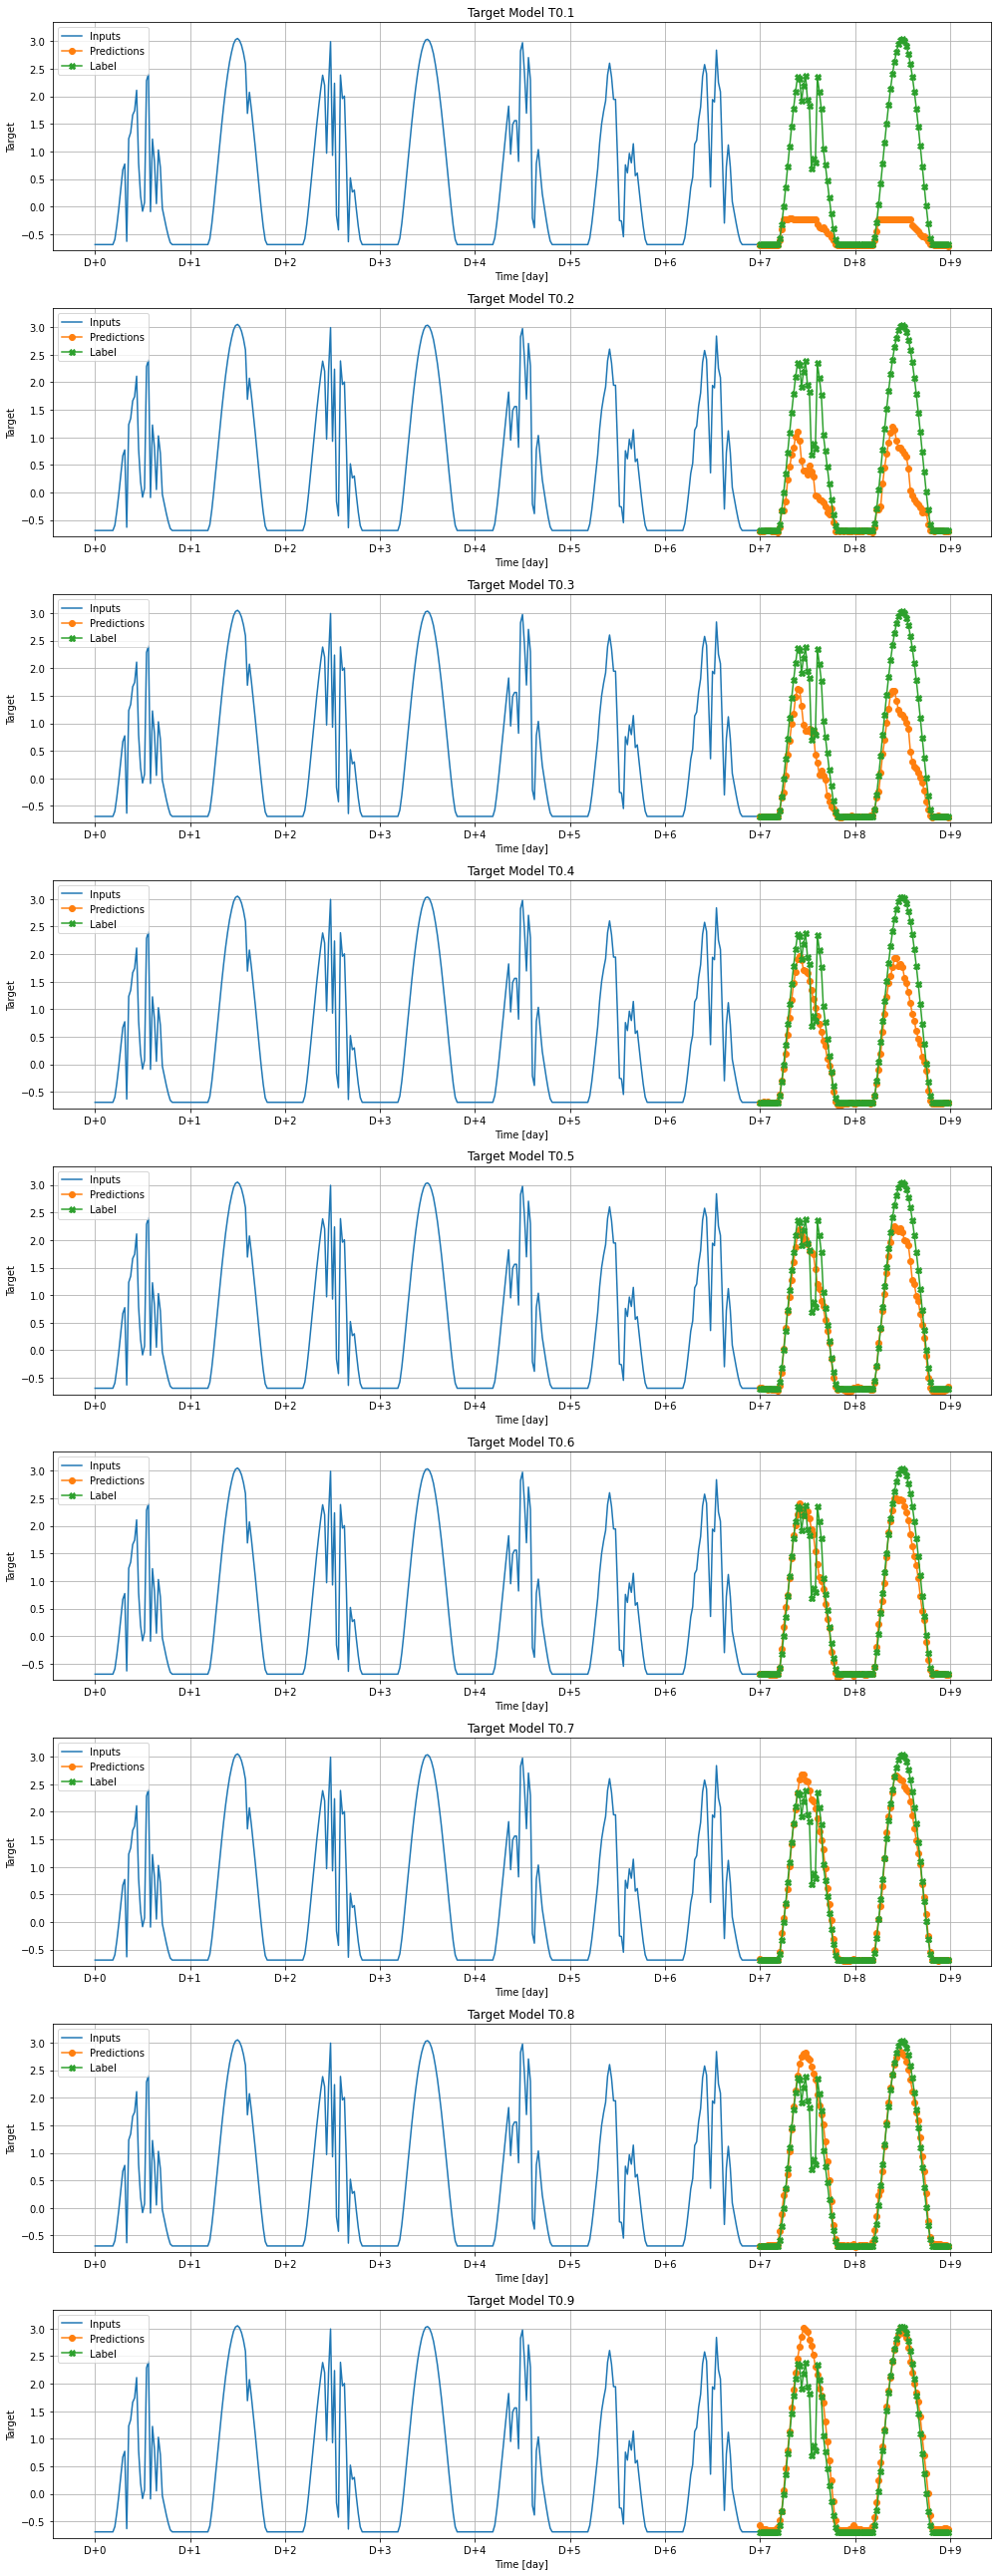

In [68]:
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models = load_latest_models(ckpt_folders)

# Now, unbatch the dataset to predict only one sequences (i.e. 7 days).
unbatched_vl_dataset = vl_dataset.unbatch().batch(1)

for t in unbatched_vl_dataset.take(1):
    x, (_, r_y) = t # inp, aux_tar, real_tar
    
    draw_pred(
        inputs = vl_tensor[:args["DAY"] * args["WINDOW_INP"], -1], # not x
        y_preds = [tf.reshape(model.predict(x)[-1], (-1, )).numpy() for model in models],
        y_true = tf.reshape(r_y, (-1, )))

## **Make Submissions**

In [69]:
%%time
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models = load_latest_models(ckpt_folders)

# Predict the test datasets.
# We need to drop auxiliary outputs and squeeze dimensions (i.e. [batch, 96, 1] => [batch, 96]).
preds = [np.array(tf.reshape(model.predict(ts_dataset)[-1], (-1, ))) for model in models]

Load latest checkpoints: ckpt/try45/P0.1/cp-049-0.0591.ckpt...
Load latest checkpoints: ckpt/try45/P0.2/cp-049-0.0933.ckpt...
Load latest checkpoints: ckpt/try45/P0.3/cp-048-0.1104.ckpt...
Load latest checkpoints: ckpt/try45/P0.4/cp-047-0.1157.ckpt...
Load latest checkpoints: ckpt/try45/P0.5/cp-046-0.1137.ckpt...
Load latest checkpoints: ckpt/try45/P0.6/cp-048-0.1025.ckpt...
Load latest checkpoints: ckpt/try45/P0.7/cp-047-0.0837.ckpt...
Load latest checkpoints: ckpt/try45/P0.8/cp-049-0.0655.ckpt...
Load latest checkpoints: ckpt/try45/P0.9/cp-050-0.0376.ckpt...
CPU times: user 3.93 s, sys: 41 ms, total: 3.97 s
Wall time: 3.85 s


In [70]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = (foo * args["TARGET_STD"]) + args["TARGET_MEAN"]
    foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [72]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.000000,0.0,0.001476,0.506424,0.168724,0.509792,0.677534,0.823574,0.990923
0.csv_Day7_0h30m,0.000000,0.0,0.141201,0.000000,0.000000,0.000000,0.078844,0.646702,0.867556
0.csv_Day7_1h00m,0.000000,0.0,0.318611,0.000000,0.000000,0.293369,0.024900,0.235977,1.135811
0.csv_Day7_1h30m,0.016277,0.0,0.398510,0.000000,0.000000,0.271963,0.068460,0.000000,0.887781
0.csv_Day7_2h00m,0.000000,0.0,0.263035,0.000000,0.000000,0.227972,0.091660,0.076748,0.739405


In [73]:
submission.to_csv(os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))